<a href="https://colab.research.google.com/github/uni-3/ml-at-work-exercise/blob/master/notebooks/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 7章 映画の推薦システムを作る
p 131

eコマースにおける推薦システムの活用場所

- 概要推薦：broad recommendation

  特集とか大まかな推薦、初心者ユーザ向け
- 利用者評価：user comments and rating

  他者の評価やコメントを表示するなど
- 通知：notification service

  pushする
- 関連アイテム推薦：item-associated recommendation

  表示したアイテムに基づく
- パーソナライゼーション：deep personalization

  個人の履歴に基づく

#### p142

In [0]:
# download data
import urllib.request
import zipfile
zfile = './ml-100k.zip'
urllib.request.urlretrieve('http://files.grouplens.org/papers/ml-100k.zip'
                           , zfile)

with zipfile.ZipFile(zfile) as z:
    z.extractall('./')

In [0]:
!ls

ml-100k  ml-100k.zip  sample_data


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [0]:
# load data
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

df_users = pd.read_csv('./ml-100k/u.user', sep='|', names=u_cols)
df_users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [0]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

# convert unix_timestamp to date 
df_ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=r_cols)
df_ratings['date'] = pd.to_datetime(df_ratings['unix_timestamp'], unit='s')
df_ratings.head()

,user_id,movie_id,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16


In [0]:
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']

df_movies = pd.read_csv('./ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin1')
df_movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [0]:
# merge data to df_lens
# on movie_id
df_movie_rating = pd.merge(df_movies, df_ratings)
df_movie_rating.head()

# on user_id
df_lens = pd.merge(df_movie_rating, df_users)
df_lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,date,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076


In [0]:
# 最も評価された、出てきた5作品のタイトル
df_lens.title.value_counts()[:5]

Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: title, dtype: int64

In [0]:
# group and sort count and mean of rating
df_gb_movie_stats = df_lens.groupby('title').agg({'rating': [np.size, np.mean]})
df_gb_movie_stats.sort_values(by=[('rating', 'mean')], ascending=False).head()

df_gb_movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

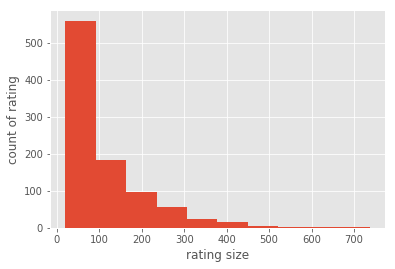

In [0]:
# 評価回数のヒストグラム
# ロングテール！
df_lens.groupby('user_id').size().sort_values(ascending=False).hist()

plt.xlabel('rating size')
plt.ylabel('count of rating')
plt.show()

In [0]:
df_gb_user_stats = df_lens.groupby('user_id').agg({'rating': [np.size, np.mean]})
df_gb_user_stats.describe()

rating            
             size        mean
count  943.000000  943.000000
mean   106.044539    3.588191
std    100.931743    0.445233
min     20.000000    1.491954
25%     33.000000    3.323054
50%     65.000000    3.620690
75%    148.000000    3.869565
max    737.000000    4.869565

#### 推薦システムの実装

In [0]:
!pip install fastFM

    100% |████████████████████████████████| 491kB 8.9MB/s 


In [0]:
# factorization machines
from sklearn.feature_extraction import DictVectorizer

In [0]:
train = [
    {'user': '1', 'item': '5', 'age': 19}
    ,{'user': '2', 'item': '43', 'age': 33}
    ,{'user': '3',  'item': '20', 'age': 55}
    ,{'user': '4', 'item': '10', 'age': 20}
]

v = DictVectorizer()

# stringはダミー変数になる(4つのベクトルと4つのベクトル)
x = v.fit_transform(train)

x.toarray()

array([[19.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [33.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [55.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [0]:
from fastFM import als
import numpy as np

In [0]:
# ユーザの評価値ベクトル各々 5, 1, 2, 4と評価したとしている
y = np.array([5.0, 1.0, 2.0, 4.0])

fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=2,
                     l2_reg_w=0.1, l2_reg_V=0.5)

fm.fit(x, y)

# user 5(age 24)がitem 10を評価したときの評価値
fm.predict(v.transform({'user': '5', 'item': '10', 'age': 24}))

array([3.60775939])

#### factorization machineで学習する

In [0]:
def load_data(filename, path='./ml-100k/'):
    data = []
    y = []
    
    with open(path+filename) as f:
        for l in f:
            (user, movieid, rating, ts) = l.split('\t')
            
            data.append({'user_id': str(user), 'movie_id': str(movieid)})
            y.append(float(rating))
    return  (data, np.array(y))

(dev_data, y_dev) = load_data('ua.base')

(test_data, y_test) = load_data('ua.test')

In [0]:
# devデータを学習、検証用に分ける
from sklearn.model_selection import train_test_split

In [0]:
v = DictVectorizer()

x_dev = v.fit_transform(dev_data)
x_test = v.transform(test_data)

np.std(y_test)
x_train, x_dev_test, y_train, y_dev_test = \
    train_test_split(x_dev, y_dev, test_size=0.1, random_state=42)

In [0]:
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

In [0]:
# parameter
n_iter = 300
step_size = 1
seed = 123
rank = 4

In [0]:
# init model
# mcmcなのでfitとpredictを同時に行わなければならない
fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)
fm.fit_predict(x_train, y_train, x_dev_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [0]:
rmse_dev_test = []
rmse_test = []

hyper_param = np.zeros((n_iter - 1, 3+2*rank), dtype=np.float64)

# iterを変化させて、predictの結果を保存する
for nr, i in enumerate(range(1, n_iter)):
    fm.random_state = i * seed
    
    y_pred = fm.fit_predict(x_train, y_train, x_dev_test, n_more_iter=step_size)
    rmse_test.append(np.sqrt(mean_squared_error(y_pred, y_dev_test)))
    hyper_param[nr, :] = fm.hyper_param_
    
# 初めの５回は無視する
# x軸の値、ステップ数
values = np.arange(1, n_iter)
x = values * step_size
burn_in = 5

x = x[burn_in:]

In [0]:
hyper_param

array([[ 7.29936807e-02,  1.01534507e+02,  1.09545845e+02, ...,
        -2.64130136e-04, -1.52355401e-03, -1.94369678e-03],
       [ 8.36490856e-01,  1.00123392e+02,  1.05959358e+02, ...,
         6.35869726e-04, -3.12144587e-03, -2.98777035e-03],
       [ 1.02700665e+00,  3.23757929e+01,  1.01870475e+02, ...,
         1.30186941e-03, -1.33292961e-03, -3.37801855e-03],
       ...,
       [ 1.41530233e+00,  4.94956660e+00,  4.84472474e+00, ...,
        -1.59330595e-01, -2.75449109e-01,  1.48574867e-02],
       [ 1.40748074e+00,  5.36560318e+00,  5.02194975e+00, ...,
        -1.80935167e-01, -2.61153633e-01,  2.88644431e-03],
       [ 1.41138484e+00,  5.22930424e+00,  5.41863118e+00, ...,
        -1.47430605e-01, -2.64029678e-01,  1.06188403e-03]])

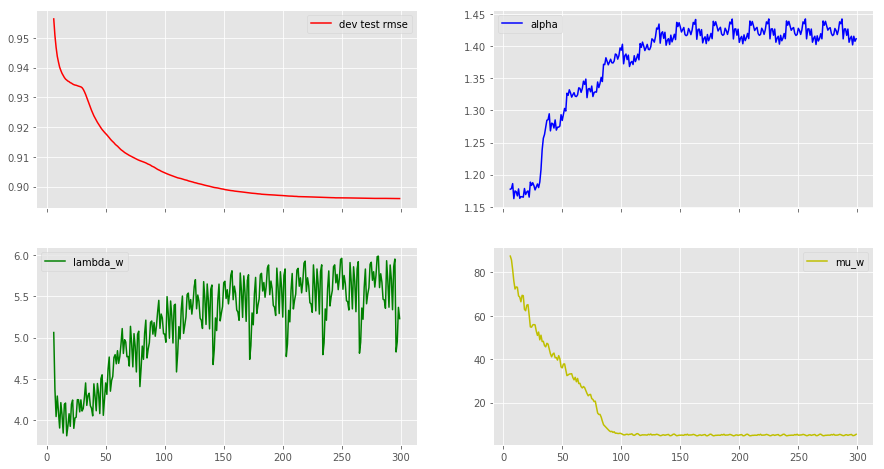

In [0]:
# rmseとハイパーパラメータをプロット
# 100くらいで収束している
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

axes[0, 0].plot(x, rmse_test[burn_in:], label='dev test rmse', color='r')
axes[0, 0].legend()
axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color='b')
axes[0, 1].legend()
axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color='g')
axes[1, 0].legend()
axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color='y')
axes[1, 1].legend()

In [0]:
# rankを変えてみる
n_iter = 100
seed = 333

rmse_test = []
ranks = [4, 8, 16, 32, 64]

for rank in ranks:
    fm = mcmc.FMRegression(n_iter=n_iter, rank=rank, random_state=seed)
    y_pred = fm.fit_predict(x_train, y_train, x_dev_test)
    
    rmse = np.sqrt(mean_squared_error(y_pred, y_dev_test))
    rmse_test.append(rmse)
    print('rank:{}\trmse:{:.3f}'.format(rank, rmse))

rank:4	rmse:0.903
rank:8	rmse:0.898
rank:16	rmse:0.896
rank:32	rmse:0.893
rank:64	rmse:0.893


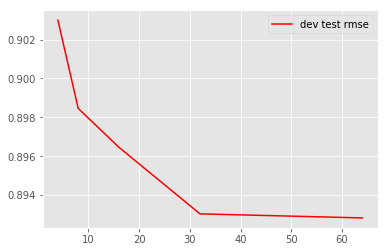

In [0]:
# rankに対するrmseをプロット
# rank32くらいから落ち着いてくる
plt.plot(ranks, rmse_test, label='dev test rmse', color='r')
plt.legend()

In [0]:
# パラメータを固定して試してみる
fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(x_train, y_train, x_test)

np.sqrt(mean_squared_error(y_pred, y_test))


0.921496840062798

In [0]:
# 評価値を標準化する
# ちょっと小さくなる
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y_train_norm = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()

fm = mcmc.FMRegression(n_iter=300, rank=32, random_state=seed)
y_pred = fm.fit_predict(x_train, y_train_norm, x_test)
np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_test))

0.9203443782544464

In [0]:
y_train.reshape(-1, 1).ravel()

array([4., 5., 2., ..., 4., 1., 1.])

In [0]:
y_train

array([4., 5., 2., ..., 4., 1., 1.])

In [0]:
y_train_norm

array([ 0.42494985,  1.31239957, -1.34994958, ...,  0.42494985,
       -2.23739929, -2.23739929])

####  他の情報も加える

In [0]:
# ダミー変数にするため、strに変換している
df_lens['user_id'] = df_lens['user_id'].astype(str)
df_lens['movie_id'] = df_lens['movie_id'].astype(str)
df_lens['year'] = df_lens['date'].apply(str).str.split('-').str.get(0)
df_lens['release_year'] = \
    df_lens['release_date'].apply(str).str.split('-').str.get(2)

In [0]:
df_lens.head()

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,date,age,sex,occupation,zip_code,year,release_year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076,1998,1995
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076,1998,1995
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076,1998,1995
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076,1998,1995
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076,1998,1995


In [0]:
# 特徴量の候補
candidate_columns = [
    ['user_id', 'movie_id', 'release_year', 'age', 'sex', 'year', 'rating'] # A
    , ['user_id', 'movie_id', 'age', 'sex', 'year', 'rating'] # B
    , ['user_id', 'movie_id', 'sex', 'year', 'rating'] # C
    , ['user_id', 'movie_id', 'age', 'sex', 'rating'] # D
    , ['user_id', 'movie_id', 'rating'] # E
]

In [0]:
rmse_test = []

for column in candidate_columns:
    # nanを削除
    filtered_df_lens = df_lens[column].dropna()
    
    # ダミー変数に変換
    v = DictVectorizer()
    x_more_feature = v.fit_transform(
        list(filtered_df_lens.drop('rating', axis=1).T.to_dict().values()))
    
    y_more_feature = filtered_df_lens['rating'].tolist()
    
    x_mf_train, x_mf_test, y_mf_train, y_mf_test = \
        train_test_split(x_more_feature, y_more_feature, test_size=0.1, random_state=42)
    
    # ratingの正規化
    scaler = StandardScaler()
    y_mf_train_norm = scaler.fit_transform(np.array(y_mf_train).reshape(-1, 1)).ravel()
    
    # 学習
    fm = mcmc.FMRegression(n_iter=500, rank=8, random_state=123)
    fm.fit_predict(x_mf_train, y_mf_train_norm, x_mf_test)
    
    # テストデータの予測結果取得 rmseを計算
    y_pred = fm.fit_predict(x_mf_train, y_mf_train_norm, x_mf_test)
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_pred), y_mf_test))
    rmse_test.append(rmse)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

(0.88, 0.9)

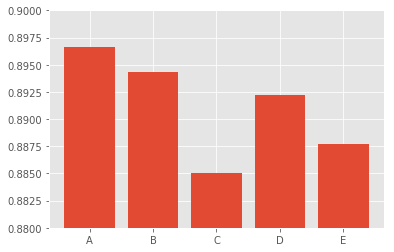

In [0]:
# plot
# どの特徴量の組み合わせがいいか
# Cが良さげ
# 特徴量の候補
#candidate_columns = [
#    ['user_id', 'movie_id', 'release_year', 'age', 'sex', 'year', 'rating'] # A
#   , ['user_id', 'movie_id', 'age', 'sex', 'year', 'rating'] # B
#    , ['user_id', 'movie_id', 'sex', 'year', 'rating'] # C
#   , ['user_id', 'movie_id', 'age', 'sex', 'rating'] # D
#    , ['user_id', 'movie_id', 'rating'] # E
#]
ind = np.arange(len(rmse_test))
bar = plt.bar(ind, height=rmse_test)

plt.xticks(ind, ('A', 'B', 'C', 'D', 'E'))
plt.ylim((0.88, 0.90))